In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,MaxPooling2D,Conv2D,Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'potato',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    # validation_split=0.2,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    # data_format=None,
    verbose=True,
)

Found 2708 files belonging to 3 classes.


In [7]:
train_size = 0.8
len(train_data)*train_size

68.0

In [8]:
train_ds = train_data.take(54)
len(train_ds)

54

In [9]:
test_ds = train_data.skip(54)
len(test_ds)

31

In [10]:
val_size=0.1
len(train_data)*val_size

8.5

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

25

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(train_data)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#shuffle the data to get good acc

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(256, 256),
  layers.Rescaling(1./255),
])
#it helps in preidction

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
# train_data = train_data.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)


In [27]:
# model = models.Sequential([
#     resize_and_rescale,
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(128,128)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(3, activation='softmax'),
#     ])

# model.build(input_shape=(128,128))
model = Sequential()
# model.add(resize_and_rescale)
# model.add(layers.InputLayer(input_shape=(128,128,3)))
layers.Resizing(256, 256)
layers.Rescaling(1./255)
model.add(layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(256,256,3)))
# model.add(layers.Resizing(128, 128))
# model.add(layers.Rescaling(1./255))
model.add(layers.MaxPooling2D((2, 2)))          
model.add(layers.Conv2D(64,  kernel_size = (3,3), activation='relu'))          
model.add(layers.MaxPooling2D((2, 2)))          
model.add(layers.Conv2D(64,  kernel_size = (3,3), activation='relu'))          
model.add(layers.MaxPooling2D((2, 2)))          
model.add(layers.Conv2D(128, (3, 3), activation='relu'))          
model.add(layers.MaxPooling2D((2, 2)))          
model.add(layers.Conv2D(128, (3, 3), activation='relu'))          
model.add(layers.MaxPooling2D((2, 2)))          
model.add( layers.Conv2D(64, (3, 3), activation='relu'))          
model.add(layers.MaxPooling2D((2, 2)))          
model.add(Flatten())        
model.add(Dense(64,activation = 'relu'))          
model.add(Dense(3,activation = 'softmax'))      


In [ ]:
from keras.applications import ResNet50
conv_base = ResNet50(
           weights = 'imagenet',
           include_top = False,
           input_shape = (256,256,3)
)




out = conv_base.output
out  = GlobalAveragePooling2D()(out)
out = Flatten()(out)
# out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.2)(out)
out = Dense(256, activation='relu')(out)
predictions = Dense(3, activation='softmax')(out)
model = Model(inputs=conv_base.input, outputs=predictions)

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 262, 262, 3)       │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 64, 64, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,768,899 (94.49 MB)

 Trainable params: 24,715,779 (94.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(
    x=train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)
# history  = model.fit(x = train_data , validation_data = val_data , epochs =15,callbacks=[early_stopping])    

Epoch 1/10
18/68 ━━━━━━━━━━━━━━━━━━━━ 22:14 27s/step - accuracy: 0.6707 - loss: 0.6675

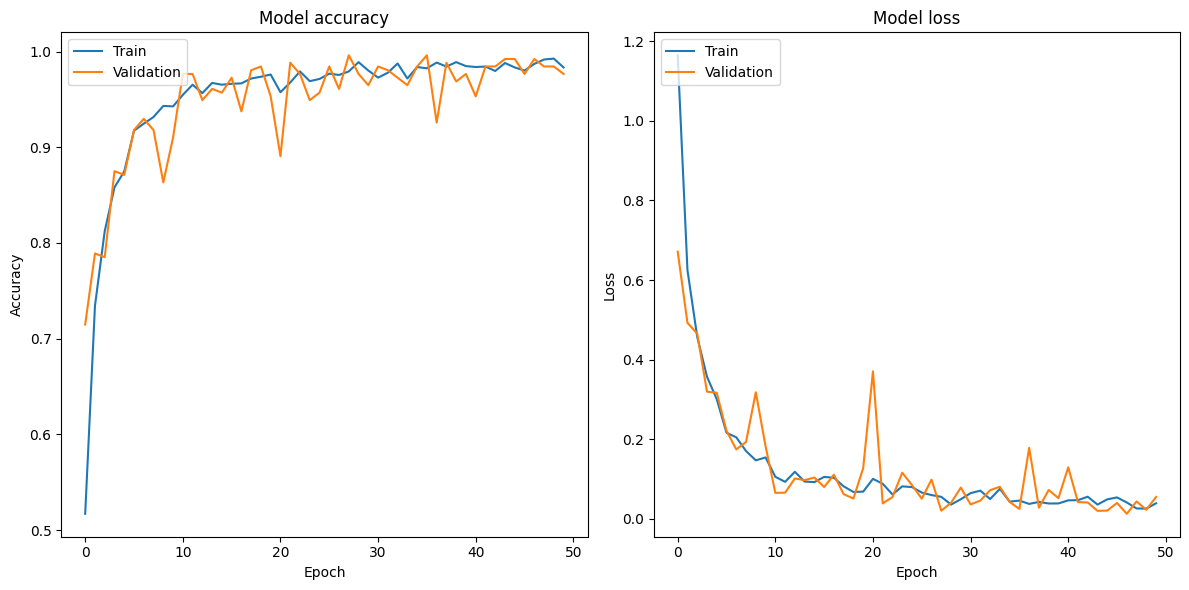

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [32]:
model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step - accuracy: 0.9655 - loss: 0.0574


[0.04020773991942406, 0.9756944179534912]

In [33]:
model.save("potato_model.keras")

In [34]:
import json
with open("potato_hist01.json","w") as f:
    json.dump(history.history , f)

In [35]:
class_names = train_data.class_names
class_names

['Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight']